In [1]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image
import requests
import time
import numpy as np
import io
from io import BytesIO
import matplotlib.pyplot as plt
%matplotlib inline
import torchvision.models as models
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import os
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
import random
from tqdm import tqdm
import json
from torch.optim.lr_scheduler import CosineAnnealingLR
import threading
import torchvision.models as models
import torch.nn as nn
from pytorch_pretrained_bert import OpenAIGPTTokenizer, OpenAIGPTModel
from nltk.corpus import wordnet
from caption_transforms import SimCLRData_Caption_Transform
from image_transforms import SimCLRData_image_Transform
from dataset import FlickrDataset,Flickr30kDataset
from models import ResNetSimCLR,OpenAI_SIMCLR
from utils import get_gpu_stats,layerwise_trainable_parameters,count_trainable_parameters,get_gpu_memory
from metrics import inter_ContrastiveLoss, intra_ContrastiveLoss
from metrics import LARS,Optimizer_simclr
from logger import Logger
from train_fns import train, test
from args import args_c
torch.cuda.empty_cache()


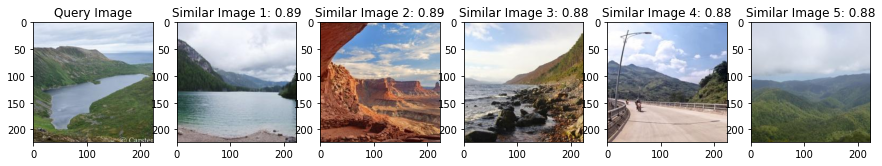

In [77]:
def compare_flickr_travel_images(query_image_path,weights_file,projection_dim,layers_to_train,images_dir,images_to_compare):
    model_resnet = ResNetSimCLR(
    model='resnet50',
    projection_dim=projection_dim,
    layers_to_train=layers_to_train,
    evaluate=True
    ).to(device)
    weights_file=weights_file
    model_resnet.load_state_dict(torch.load(weights_file))
    model_resnet.eval()
    model_resnet.projection_head=nn.Identity()
    query_image_path =query_image_path
    image = Image.open(query_image_path)
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    query_image = preprocess(image).unsqueeze(0)
    with torch.no_grad():
        features = model_resnet(query_image,device)
    query_features = features.cpu().squeeze().numpy()
    similarities = []
    image_paths = []
    for root, dirs, files in os.walk(images_dir):
        for file in files:
            if file.endswith('.jpg'):
                image_path = os.path.join(root, file)
                image = Image.open(image_path)
                image_tensor = preprocess(image).unsqueeze(0)
                with torch.no_grad():
                    image_features = model_resnet(image_tensor,device)
                    image_features = image_features.cpu().squeeze().numpy()
                similarity = (np.dot(query_features, image_features) / (np.linalg.norm(query_features) * 
                                                                       np.linalg.norm(image_features)))
                similarities.append(similarity)
                image_paths.append(image_path)
    k = images_to_compare
    indices = np.argsort(similarities)[::-1][:k]
    similar_images = [image_paths[i] for i in indices]
    query_image = Image.open(query_image_path)
    fig, axs = plt.subplots(1, k+1, figsize=(15, 15))
    axs[0].imshow(query_image)
    axs[0].set_title('Query Image')
    for i, image_path in enumerate(similar_images):
        image = Image.open(image_path)
        similarity_score = similarities[indices[i]]
        axs[i+1].imshow(image)
        axs[i+1].set_title('Similar Image {}: {:.2f}'.format(i+1, similarity_score))

    plt.show()
compare_flickr_travel_images(query_image_path='/home1/08629/pradhakr/cv_project/data/test/52265719626_aebee6d6d7.jpg',
                    weights_file='/work/08629/pradhakr/maverick2/cv_project/image_caption/image_model_5.pth',
                    projection_dim=128,
                    layers_to_train=['layer3','layer4'],
                    images_dir='/home1/08629/pradhakr/cv_project/data/train',
                    images_to_compare=5
                             )


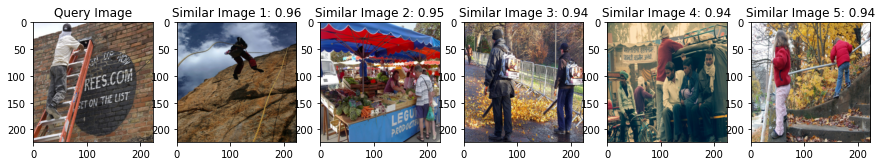

In [78]:
def compare_flickr_30k_images(query_image,weights_file,projection_dim,layers_to_train,dataset,images_to_compare):
    model_resnet = ResNetSimCLR(
    model='resnet50',
    projection_dim=projection_dim,
    layers_to_train=layers_to_train,
    evaluate=True
    ).to(device)
    weights_file=weights_file
    model_resnet.load_state_dict(torch.load(weights_file))
    model_resnet.eval()
    model_resnet.projection_head=nn.Identity()
    image = query_image
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        #transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    query_image_new = preprocess(image).unsqueeze(0)
    with torch.no_grad():
        features = model_resnet(query_image_new,device)
    query_features = features.cpu().squeeze().numpy()
    similarities = []
    images_list= []
    for image in dataset:
        image=image[0]
        image_tensor = preprocess(image).unsqueeze(0)
        with torch.no_grad():
            image_features = model_resnet(image_tensor,device)
            image_features = image_features.cpu().squeeze().numpy()
        similarity = (np.dot(query_features, image_features) / (np.linalg.norm(query_features) * 
                                                               np.linalg.norm(image_features)))
        similarities.append(similarity)
        images_list.append(image)
    k = images_to_compare
    indices = np.argsort(similarities)[::-1][:k]
    similar_images = [images_list[i] for i in indices]
    query_image = query_image
    fig, axs = plt.subplots(1, k+1, figsize=(15, 15))
    axs[0].imshow(query_image.permute(1,2,0))
    axs[0].set_title('Query Image')
    for i, image in enumerate(similar_images):
        similarity_score = similarities[indices[i]]
        axs[i+1].imshow(image.permute(1,2,0))
        axs[i+1].set_title('Similar Image {}: {:.2f}'.format(i+1, similarity_score))

    plt.show()    
compare_flickr_30k_images(query_image=train_set[566][0],
                          weights_file='/work/08629/pradhakr/maverick2/cv_project/flickr30k_imagecaption/image_model1_30k.pth',
                        projection_dim=128,
                        layers_to_train=['layer3','layer4'],
                        dataset=val_set,
                        images_to_compare=5)

In [87]:
resnet_model = ResNetSimCLR(
    model='resnet50',
    projection_dim=128,
    layers_to_train=['layer3','layer4'],
    evaluate=False
).to(device)

weights_file='/work/08629/pradhakr/maverick2/cv_project/flickr30k_imagecaption/image_model1_30k.pth'
resnet_model.load_state_dict(torch.load(weights_file))
resnet_model.eval()
resnet_model.projection_head=nn.Identity()
gpt_model = OpenAI_SIMCLR(
    model='openai-gpt',
    projection_dim=128,
    layers_to_train=['h.10','h.11'],
    encoder_last_layer=2048,
    evaluate=False
).to(device)
txt_weights_file='/work/08629/pradhakr/maverick2/cv_project/flickr30k_imagecaption/text_model1_30k.pth'
gpt_model.load_state_dict(torch.load(txt_weights_file))
gpt_model.eval()
gpt_model.projection_head=nn.Identity()


ftfy or spacy is not installed using BERT BasicTokenizer instead of SpaCy & ftfy.


OpenAI_SIMCLR(
  (backbone): OpenAIGPTModel(
    (tokens_embed): Embedding(40478, 768)
    (positions_embed): Embedding(512, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): Block(
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_1): BertLayerNorm()
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): BertLayerNorm()
      )
      (1): Block(
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_1): BertLayerNorm()
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, in

In [70]:
for i in val_loader:
    s=i
    break

In [80]:
#s[3]

In [97]:
image_features_list = []
text_features_list = []
caption_number=1
for i, batch in tqdm(enumerate(train_loader)):
    images, caption = batch[0], batch[3]
    with torch.no_grad():
        image_features= resnet_model(images,device)
        caption_features = gpt_model(caption, device)
        text_features_list.append(caption_features.cpu().numpy())
        image_features_list.append(image_features.cpu().numpy())

233it [06:55,  1.78s/it]


In [98]:
image_features_arr = np.concatenate(image_features_list)
text_features_arr = np.concatenate(text_features_list)
similarity_matrix = cosine_similarity(image_features_arr, text_features_arr)
similarity_matrix[0]

array([-0.00085119, -0.04828745,  0.03741694, ..., -0.00679344,
       -0.03393341, -0.01970546], dtype=float32)